In [1]:
'''
Written by Xeerak Agha
11/5/2025
'''
import torch
from torch import nn
from torch.functional import F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torch.utils.checkpoint import checkpoint

import lpips
from pytorch_msssim import ssim

import os
from pathlib import Path
import random
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from res.plot_lib import set_default
from typing import Tuple

if torch.cuda.is_available():
    device = "cuda:1"
else:
    device = "cpu"
device

'cuda:1'

In [2]:
data_path = Path("datasets")
image_path = data_path / "agan"

train_dir = image_path / "train" # can do str: datasets/agan/train
test_dir = image_path / "test_a" # can do str: datasets/agan/test_a

train_dir, test_dir

(PosixPath('datasets/agan/train'), PosixPath('datasets/agan/test_a'))

### Define Dataset class

In [ ]:
class AganDataset(Dataset):
    def __init__(self, targ_dir: str, transform=None, seed=42):
        data_ext = list(Path(targ_dir).glob("data/*"))[0].suffix
        gt_ext = list(Path(targ_dir).glob("gt/*"))[0].suffix
        
        self.data_paths = sorted(list(Path(targ_dir).glob(f"data/*{data_ext}")))
        self.gt_paths = sorted(list(Path(targ_dir).glob(f"gt/*{gt_ext}")))
        self.seed = seed
        self.transform = transform

    def load_image(self, index: int) -> Image.Image:
        data_path, gt_path = self.data_paths[index], self.gt_paths[index]
        return Image.open(data_path).convert("RGB"), Image.open(gt_path).convert("RGB")

    def get_length(self) -> Tuple[int, int]:
        return len(self.data_paths), len(self.gt_paths)
    
    def __len__(self) -> int:
        return min(len(self.data_paths), len(self.gt_paths))

    def __getitem__(self, index: int):
        data_img, gt_img = self.load_image(index)

        if self.transform:
            torch.manual_seed(self.seed)
            data_img  = self.transform(data_img)
            torch.manual_seed(self.seed)
            gt_img = self.transform(gt_img)

        return data_img, gt_img

### Instantiate Dataset and DataLoader

In [ ]:
train_transform = transforms.Compose([
    transforms.CenterCrop(size=(480, 480)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5]) 
])

test_transform = transforms.Compose([
    transforms.CenterCrop(size=(480, 480)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5])
])

train_dataset = AganDataset(targ_dir = train_dir,
                            transform = train_transform)
test_dataset = AganDataset(targ_dir = test_dir,
                           transform = test_transform)
train_dataset, test_dataset

In [ ]:
train_dataloader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=16, shuffle=False)
train_dataloader, test_dataloader

### Define Model Architecture

#### TODO: Use pretrained feature extractor backbone AND gated convolution with instancenorm2d similar to inpainting architecture

In [6]:
class VisualAttentionNet(nn.Module):
    def __init__(self, in_channels=3, hidden_channels=32, iteration=5, use_checkpoint=True):
        super(VisualAttentionNet, self).__init__()
        self.iteration = iteration
        self.hidden_channels = hidden_channels
        self.use_checkpoint = use_checkpoint

        # Deterministic convoutional refinement layers
        self.det_conv0 = nn.Conv2d(in_channels + 1, 32, kernel_size=3, padding=1)
        self.det_conv1 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.det_conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.det_conv3 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.det_conv4 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.det_conv5 = nn.Conv2d(32, 32, kernel_size=3, padding=1)

        # ConvLSTM-style gating layers
        self.conv_i = nn.Conv2d(32 + hidden_channels, hidden_channels, kernel_size=3, padding=1)
        self.conv_f = nn.Conv2d(32 + hidden_channels, hidden_channels, kernel_size=3, padding=1)
        self.conv_g = nn.Conv2d(32 + hidden_channels, hidden_channels, kernel_size=3, padding=1)
        self.conv_o = nn.Conv2d(32 + hidden_channels, hidden_channels, kernel_size=3, padding=1)

        # Output mask generation 
        self.det_conv_mask = nn.Conv2d(hidden_channels, 1, kernel_size=3, padding=1)

    def _refine_block(self, inp, h, c):
        # Residual conv blocks (non-in-place addition to limit graph depth)
        out = self.det_conv0(inp)
        for conv in [self.det_conv1, self.det_conv2, self.det_conv3, self.det_conv4, self.det_conv5]:
            # out = F.relu(conv(out) + out) # skip connection additions of feature map of previous and current layer
            res = out
            out = F.relu(conv(out))
            out = out + res

             # ConvLSTM style gating layers
            combined = torch.cat((out, h), dim=1)
            i = torch.sigmoid(self.conv_i(combined))
            f = torch.sigmoid(self.conv_f(combined))
            g = torch.tanh(self.conv_g(combined))
            o = torch.sigmoid(self.conv_o(combined))

            c = f * c + i * g
            h = o * torch.tanh(c)

            # Update mask prediction
            mask = self.det_conv_mask(h)

            return mask, h, c

    def forward(self, x):
        batch_size, _, row, col = x.size()
        device = x.device

        # Initialize mask, hidden state, and cell state
        mask = torch.ones(batch_size, 1, row, col, device=device) * 0.5
        h = torch.zeros(batch_size, self.hidden_channels, row, col, device=device)
        c = torch.zeros(batch_size, self.hidden_channels, row, col, device=device)

        mask_list = []
        
        for _ in range(self.iteration):
            # Concatenate input and mask
            inp = torch.cat((x, mask), dim=1)
            
            if self.use_checkpoint:
                mask, h, c = checkpoint(self._refine_block, inp, h, c, use_reentrant=False)
            else:
                mask, h, c = self._refine_block(inp, h, c)

        return mask

In [7]:
# forward pass test
attNet = VisualAttentionNet().to(device)
x = torch.randn(1, 3, 480, 480).to(device)
mask_list = attNet(x)
for i in mask_list:
    print(type(i), i.shape) 

<class 'torch.Tensor'> torch.Size([1, 480, 480])


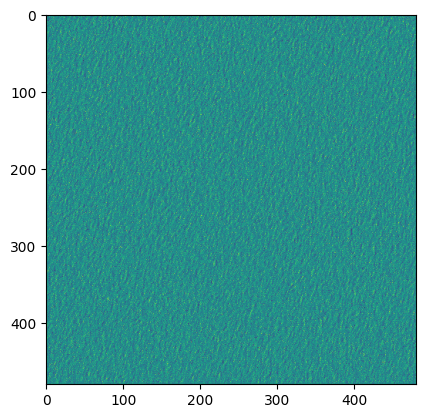

In [8]:
# Visualize masks
mask1 = (mask_list[0]+1/2).clamp(0,1)
mask1 = mask1.squeeze().detach().cpu().numpy()
mask1 *= 255
plt.imshow(mask1)

In [9]:
class SkipVAE(nn.Module):
    def __init__(self, latent_dim=256):
        super().__init__()
        self.latent_dim = latent_dim
        self.iteration = 2
        self.mask_list = []

        ### Visual Attnetion Mask ###
        self.attnMask = VisualAttentionNet(in_channels=3, hidden_channels=32, iteration=self.iteration)

        ### Encoder ###
        # input channels: 3 from X [B, C, H, W]
        self.encoder = nn.Sequential(
            nn.Conv2d(4, 16, 4, 2, 1), nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(16, 32, 4, 2, 1), nn.BatchNorm2d(32), nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(32, 64, 4, 2, 1), nn.BatchNorm2d(64), nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1), nn.BatchNorm2d(128), nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1), nn.BatchNorm2d(256), nn.LeakyReLU(0.2, inplace=True)
        )

        self.flatten_dim = 256*15*15
        self.fc_mu_logvar = nn.Linear(self.flatten_dim, 2*latent_dim)

        ### Feature encoder ### 
        self.x_encoder = nn.Sequential(
            nn.Sequential(nn.Conv2d(3, 16, 4, 2, 1),nn.LeakyReLU(0.2, inplace=True)),
            nn.Sequential(nn.Conv2d(16, 32, 4, 2, 1), nn.BatchNorm2d(32), nn.LeakyReLU(0.2, inplace=True)),
            nn.Sequential(nn.Conv2d(32, 64, 4, 2, 1), nn.BatchNorm2d(64), nn.LeakyReLU(0.2, inplace=True)),
            nn.Sequential(nn.Conv2d(64, 128, 4, 2, 1), nn.BatchNorm2d(128), nn.LeakyReLU(0.2, inplace=True)),
            nn.Sequential(nn.Conv2d(128, 256, 4, 2, 1), nn.BatchNorm2d(256), nn.LeakyReLU(0.2, inplace=True))
        )

        ### Decoder ###
        self.fc_decode = nn.Linear(latent_dim, self.flatten_dim)
        self.decoder = nn.ModuleList([
            nn.Sequential(nn.ConvTranspose2d(256 + latent_dim, 128, 4, 2, 1), nn.BatchNorm2d(128), nn.ReLU(True)),
            nn.Sequential(nn.ConvTranspose2d(128 + 128, 64, 4, 2, 1), nn.BatchNorm2d(64), nn.ReLU(True)),
            nn.Sequential(nn.ConvTranspose2d(64 + 64, 32, 4, 2, 1), nn.BatchNorm2d(32), nn.ReLU(True)),
            nn.Sequential(nn.ConvTranspose2d(32 + 32, 16, 4, 2, 1), nn.BatchNorm2d(16), nn.ReLU(True)),
            nn.Sequential(nn.ConvTranspose2d(16 + 16, 3, 4, 2, 1), nn.Tanh())
        ])
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.rand_like(std)
        return mu + eps * std

    def forward(self, x):
        B, C, H, W = x.size()
        
        # Learn attention mask
        mask = self.attnMask(x)
        mask = torch.sigmoid(mask) # bind attention weights to [0, 1]

        # Encode input
        x_and_mask = torch.cat([x, mask], dim=1) # concatenates x and mask 
        h = self.encoder(x_and_mask)
        h_flat = h.view(h.size(0), -1) # get batch dim: h.size()[0] 
        mu_logvar = self.fc_mu_logvar(h_flat)
        mu, logvar = torch.chunk(mu_logvar, 2, dim=1) # tensor, number of chunks, along which dimension
        z = self.reparameterize(mu, logvar) # to take derivative of a stochastic process

        # Skip-Connection Encoder
        skips = []
        feat = x
        for layer in self.x_encoder:
            feat = layer(feat)
            skips.append(feat)
        skips = skips[::-1]

        # decode conditioned on x and z
        z_map = z.view(z.size(0), z.size(1), 1, 1) # add unit height and width
        z_map = z_map.expand(-1, -1, skips[0].size(2), skips[0].size(3)) # make sure this matches size with previous encoder layer output
        h = torch.cat([skips[0], z_map], dim=1) # concatenate the z_map and x feature map for x_encoder

        for i, dec in enumerate(self.decoder):
            h = dec(h)
            if i + 1 < len(skips):
                h = torch.cat([h, skips[i+1]], dim=1)
        y_hat = h
        
        return y_hat, mu, logvar, mask

In [10]:
# forward pass test
model = SkipVAE().to(device)
model.train()
x = torch.randn(1, 3, 480, 480).to(device)
a, b, c, d = model(x)
a.shape, b.shape, c.shape, d.shape

(torch.Size([1, 3, 480, 480]),
 torch.Size([1, 256]),
 torch.Size([1, 256]),
 torch.Size([1, 1, 480, 480]))

In [11]:
# Visualizing forward pass from normalized + TanH activation -> standard uint8
y_hat_vis = ((a + 1) / 2).clamp(0, 1)
y_hat_vis = (y_hat_vis * 255).to(torch.uint8)
img = y_hat_vis.squeeze().permute(1,2,0).detach().cpu().numpy()

# Visualize masks
mask = (d+1/2).clamp(0,1)
mask = mask.squeeze().detach().cpu().numpy()
mask *= 255

(np.float64(-0.5), np.float64(479.5), np.float64(479.5), np.float64(-0.5))

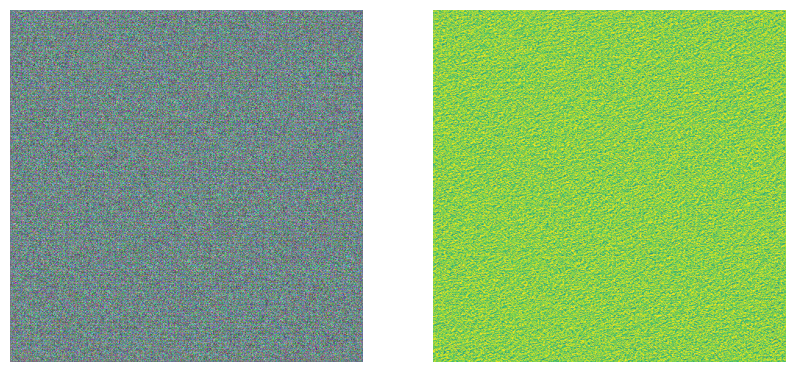

In [12]:
# Plot image and mask from forward pass
plt.figure(figsize=(10,7))
plt.subplot(1,2,1)
plt.imshow(img)
plt.axis(False)
plt.subplot(1,2,2)
plt.imshow(mask)
plt.axis(False)

### Define loss function

In [13]:
# define lpips model
lpips_alex = lpips.LPIPS(net="alex").to(device)
lpips_alex.eval()

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/home/xeerak/anaconda3/envs/raingen/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/xeerak/anaconda3/envs/raingen/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /home/xeerak/anaconda3/envs/raingen/lib/python3.10/site-packages/lpips/weights/v0.1/alex.pth


LPIPS(
  (scaling_layer): ScalingLayer()
  (net): alexnet(
    (slice1): Sequential(
      (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
      (1): ReLU(inplace=True)
    )
    (slice2): Sequential(
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU(inplace=True)
    )
    (slice3): Sequential(
      (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
    )
    (slice4): Sequential(
      (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
    )
    (slice5): Sequential(
      (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
    )
  )
  (lin0): NetLinLayer(
    (model): Sequential(
      (0): D

In [14]:
def multiscale_lpips_loss(y_hat, y, lpips_model, scales=[1.0, 0.5, 0.25]):
    total_loss = 0.0
    for s in scales:
        if s != 1.0:
            y_hat_scaled = F.interpolate(y_hat, scale_factor=s, mode="area")
            y_scaled = F.interpolate(y, scale_factor=s, mode="area")
        else:
            y_hat_scaled, y_scaled = y_hat, y

        lpips_val = lpips_model(y_hat_scaled, y_scaled)
        total_loss += lpips_val.mean()

    return total_loss / len(scales)

In [15]:
def vae_loss(y_hat, y, mu, logvar, β, lpips_model, penalty_lpips, penalty_ssim):
    # Reconstruction loss - mse + perceptual + structural similarity
    mse = F.mse_loss(y_hat, y, reduction="mean")
    lpips_loss = multiscale_lpips_loss(y_hat, y, lpips_model)
    ssim_loss = 1 - ssim(y_hat, y, data_range=2.0, size_average=True)
    recon = mse + penalty_lpips * lpips_loss + penalty_ssim * ssim_loss
    
    # KL Divergence
    KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    return recon + β * KLD, recon, KLD # ELBO + beta * Kullback-Leibler Divergence, ELBO, KLD

### Define learning rate, optimizer, and learning rate scheduler

In [16]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

optimizer = torch.optim.Adam(
    params=model.parameters(), 
    lr=1e-4,
    betas=(0.5, 0.999))



BETA_MAX = 1.5
BETA_WARMUP_EPOCHS = 100
patience = 10
scheduler = ReduceLROnPlateau(
    optimizer, mode="min", factor=0.5, patience=patience
)

### Define display image function

In [17]:
def display_images(in_, out, mask, n=1, label=None, count=False):
    in_batch = in_.detach().cpu() if in_ is not None else None
    out_batch = out.detach().cpu()
    mask_batch = mask.detach().cpu() # [10, 1, 480, 480]
    batch_size = out_batch.size(0)
    num_to_show = min(4 * n, batch_size)

    for N in range(n):
        batch_start = 2*N
        if batch_start >= batch_size:
            break

        ### Masks ###
        if mask_batch is not None:
            plt.figure(figsize=(18, 4))
            for  i in range(4):
                idx = batch_start = i
                if idx >= batch_size:
                    break
                mask = mask_batch[idx].squeeze().detach().cpu()  # [1, 480, 480]
                mask *= 255
                plt.subplot(1, 4, i+1)
                plt.imshow(mask)
                plt.axis("off")

        
        ### Original Images ###
        if in_batch is not None:
            plt.figure(figsize=(18,4))
            for i in range(4):
                idx = batch_start + i
                if idx >= batch_size:
                    break
                img = in_batch[idx].squeeze().permute(1,2,0).detach().cpu()
                std, mean = 0.5, 0.5
                img = (img * std) + mean # denormalize tensor [-1, 1] -> [0, 1]
                img = torch.clamp(img, 0.0, 1.0)
                img = (img * 255).to(torch.uint8)
                plt.subplot(1, 4, i+1)
                plt.imshow(img)
                plt.axis("off")
        
        ### Reconstructed images ### 
        plt.figure(figsize=(18,4))
        for i in range(4):
            idx = batch_start + i
            if idx >= batch_size:
                break
            img = out_batch[idx].permute(1, 2, 0).detach().cpu()
            img = (img * std) + mean
            img = (img * 255).to(torch.uint8)
            plt.subplot(1, 4, i+1)
            plt.imshow(img)
            plt.axis("off")
            if count:
                plt.title(str(idx), color='w')
        plt.show()

### Define train/test loop

In [18]:
class EarlyStopping:
    def __init__(self, patience, verbose=False, delta=0, path="./attentive_vae_weights/attentive_vae_last.pth", trace_func=print):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = float("inf")
        self.delta = delta
        self.path = path
        self.trace_func = trace_func

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            self.trace_func(f"Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model ... ")
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [1]:
import math

epochs = 1000
last_epoch = 0
codes = dict(mus=list(), logvars=list())

train_loss_lst, recon_term_lst, kl_term_lst = list(), list(), list()
test_loss_lst = list()

early_stopping = EarlyStopping(patience = 10, verbose=True)

for epoch in range(0, epochs+1):
    # Smooth logistic beta warmup
    beta = BETA_MAX / (1 + math.exp(-10 * (epoch / BETA_WARMUP_EPOCHS - 0.5)))
    beta = min(max(beta, 0.0), BETA_MAX)
    
    # Training loop
    model.train()
    train_loss, compare_recon_loss = 0.0, 0.0
    for x, y in train_dataloader:
        x, y = x.to(device), y.to(device)
        y_hat, mu, logvar, mask = model(x)
        loss, recon_term, kl_term = vae_loss(y_hat, y, mu, logvar, beta, lpips_model=lpips_alex, penalty_lpips=0.5, penalty_ssim=0.5)
        train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f" Epoch: {epoch} | Train loss: {train_loss / len(train_dataloader.dataset):.4f} | Recon Term: {recon_term.item() / len(train_dataloader.dataset):.4f} | KL Term: {kl_term.item() / len(train_dataloader.dataset):.4f}")
    train_loss_lst.append(train_loss / len(train_dataloader.dataset))
    recon_term_lst.append(recon_term.item() / len(train_dataloader.dataset))
    kl_term_lst.append(kl_term.item() / len(train_dataloader.dataset))
    
    # Test loop
    means, logvars = list(), list()
    
    with torch.inference_mode():
        model.eval()
        test_loss = 0.0
        for x, y in test_dataloader:
            x, y = x.to(device), y.to(device)
            y_hat, mu, logvar, mask = model(x)
            # Reconstruction loss - mse + perceptual + structural similarity
            mse = F.mse_loss(y_hat, y, reduction="mean")
            lpips_loss = multiscale_lpips_loss(y_hat, y, lpips_alex)
            ssim_loss = 1 - ssim(y_hat, y, data_range=2.0, size_average=True)
            recon = mse + 0.5 * lpips_loss + 0.5 * ssim_loss
            test_loss += recon.item()
            means.append(mu.detach())
            logvars.append(logvar.detach())
    test_loss /= len(test_dataloader.dataset)
    print(f"Test loss: {test_loss:.4f}")
    test_loss_lst.append(test_loss / len(test_dataloader.dataset))
    codes['mus'].append(torch.cat(means))
    codes['logvars'].append(torch.cat(logvars))
    

    if epoch % 10 == 0:
        display_images(x, y_hat, mask, 1, f"Epoch {epoch}")
        torch.save(model.state_dict(), f"./attentive_vae_weights/attentive_vae_epoch_{epoch}.pth")

    scheduler.step(test_loss)
    early_stopping(test_loss, model)
    
    if early_stopping.early_stop:
        last_epoch = epoch
        print("Early stopping triggered!")
        break

Overwriting engine.py


### Plot training/validation loss curves

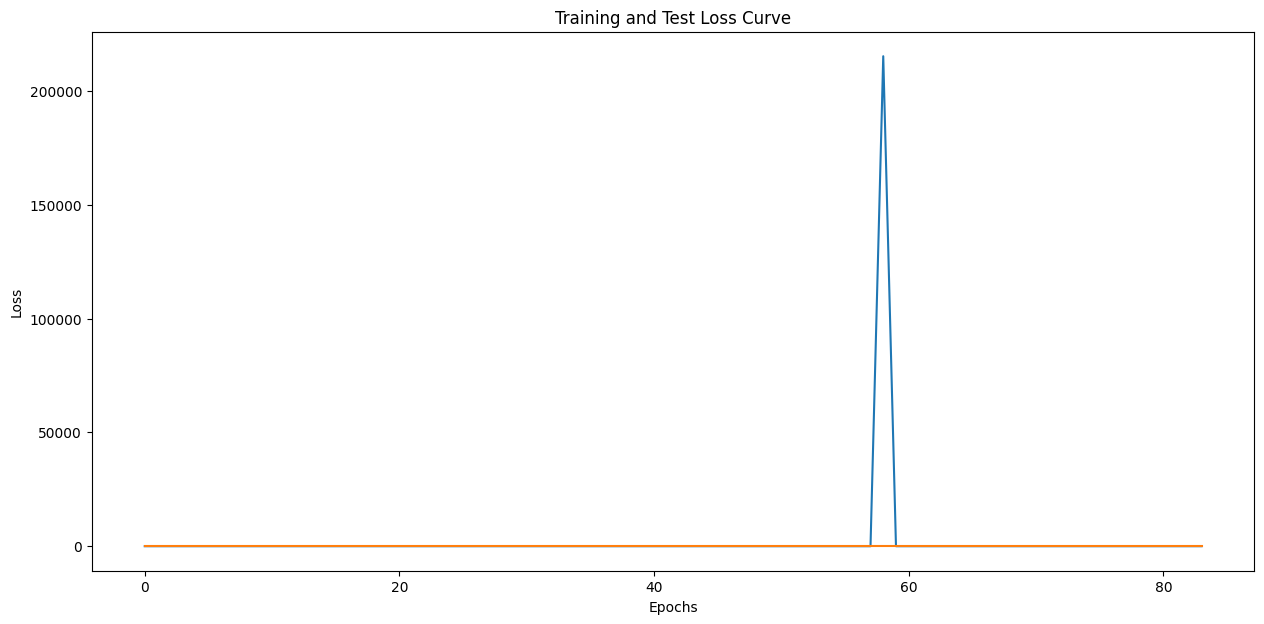

In [20]:
plt.figure(figsize=(15, 7))
plt.plot(range(last_epoch+1), train_loss_lst, label="train loss")
plt.plot(range(last_epoch+1), test_loss_lst, label="test loss")
plt.title("Training and Test Loss Curve")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [53]:
X, E = list(), list() # input, embeddings
N = 1000
epochs = (0, 20, 40, 60, 80)
for epoch in epochs:
    X.append(codes['mus'][epoch][:N])
    E.append(TSNE(n_components=2).fit_transform(X[-1].detach().cpu()))

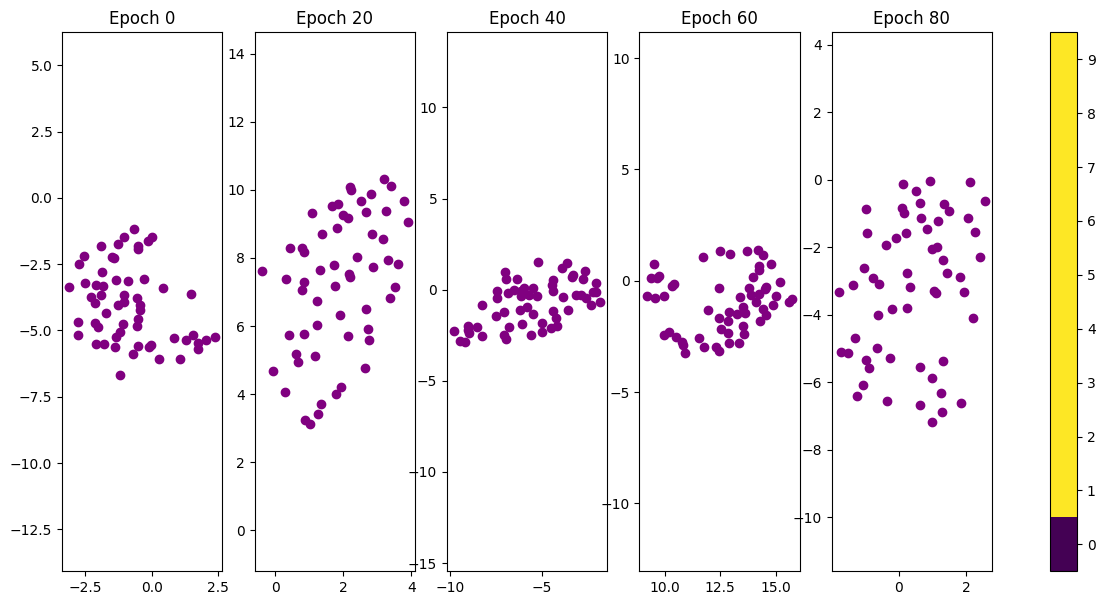

In [54]:
f, a = plt.subplots(ncols=5, figsize=(15,7))
for i, e in enumerate(epochs):
    s = a[i].scatter(E[i][:,0], E[i][:,1], c='purple')
    a[i].grid(False)
    a[i].set_title(f'Epoch {e}')
    a[i].axis('equal')
f.colorbar(s, ax=a[:], ticks=np.arange(10), boundaries=np.arange(11) - .5)

In [44]:
# Load the best models state dictionary
model.load_state_dict(torch.load("./attentive_vae_weights/attentive_vae_last.pth", map_location=device))

<All keys matched successfully>

### Testining trained model on inference dataset 
Randomly sample 3-5 samples, transform them, model inference, display them

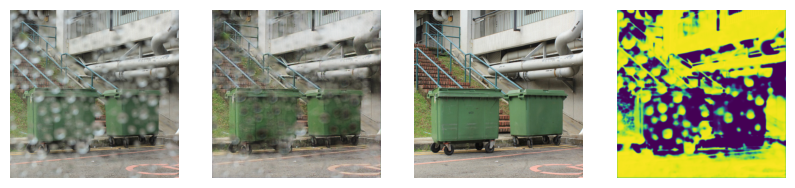

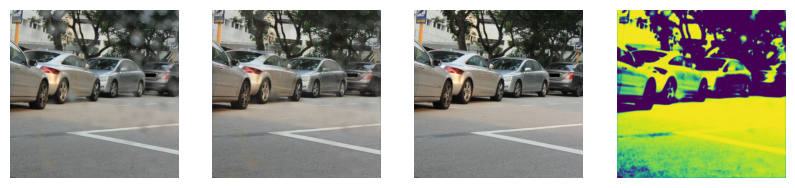

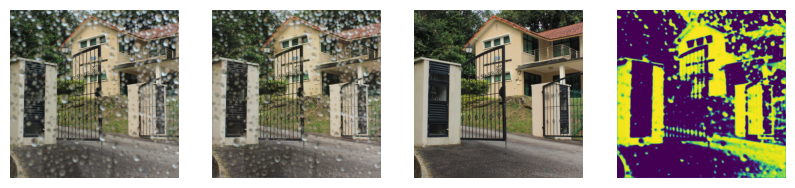

In [55]:
inference_transform = transforms.Compose([
    transforms.CenterCrop(size=(480, 480)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5])
])

inference_data_list = sorted(list(Path("datasets/agan/test_b/").glob("data/*.jpg")))
inference_gt_list = sorted(list(Path("datasets/agan/test_b/").glob("gt/*.jpg")))

random.seed(42)
sample_indices = random.sample(range(0,len(inference_data_list)), 3)
# img = Image.open(inference_data_list[sample_indices[0]])
# img = inference_transform(img).unsqueeze(dim=0)
# img.shape

for i in range(len(sample_indices)):
    x, y = Image.open(inference_data_list[sample_indices[i]]), Image.open(inference_gt_list[sample_indices[i]])
    x, y = inference_transform(x).unsqueeze(dim=0).to(device), inference_transform(y)
    model.eval()
    with torch.inference_mode():
        y_hat, mu, logvar, mask = model(x)

        # plt.figure(figsize=(10,10))
        # # Visualize the mu and logvar of the model estimation
        # mu = mu.detach().cpu().numpy()
        # logvar = logvar.detach().cpu().numpy()
        
        # fig, axes = plt.subplots(1, 2, figsize=(12, 5))
        # axes[0].hist(mu.flatten(), bins=50, color='skyblue')
        # axes[0].set_title("Distribution of μ (mean)")
        
        # axes[1].hist(logvar.flatten(), bins=50, color='salmon')
        # axes[1].set_title("Distribution of log σ² (log-variance)")
        # plt.show()
        
        # post-process input and gt
        std, mean = 0.5, 0.5
        x = x.squeeze().permute(1,2,0).detach().cpu()
        x = (x * std) + mean
        x = torch.clamp(x, 0.0, 1.0)
        x = (x*255).to(torch.uint8)
    
        y = y.permute(1,2,0).detach()
        y = (y * std) + mean
        y = torch.clamp(y, 0.0, 1.0)
        y = (y*255).to(torch.uint8)
    
        # post-process reconstruction
        y_hat = y_hat.squeeze().permute(1,2,0).detach().cpu()
        y_hat = (y_hat * std) + mean
        y_hat = (y_hat * 255).to(torch.uint8)

        # mask 
        mask = mask.squeeze().detach().cpu()
        mask *= 255
        
        plt.figure(figsize=(10,30))
        plt.subplot(1,4,1)
        plt.imshow(x)
        plt.axis(False)
    
        plt.subplot(1,4,2)
        plt.imshow(y_hat)
        plt.axis(False)
    
        plt.subplot(1,4,3)
        plt.imshow(y)
        plt.axis(False)

        plt.subplot(1,4,4)
        plt.imshow(mask)
        plt.axis(False)

# 